# STEP 1: DATA CLEANING

In [1]:
# Importing dependencies
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import randint
import tensorflow as tf
from tensorflow.keras.models import Sequential


In [2]:
# Importing csv files

# Household data
hh_data = pd.read_csv(Path("Data/faps_household_puf.csv"))
hh_data.head()

,hhnum,initintrvmon,startmon,initfinaldays,initialdate_flag,startdate_edit,startlag,matchconsenthh,nonmetro,region,...,feedback2,feedback3,feedback4_1,feedback4_2,feedback4_3,feedback4_4,feedback4_5,feedback4_6,feedback4_7,feedback4_8
0,100012,1,1,8,0,0,1,1,1,3,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100015,8,8,8,0,0,1,1,0,3,...,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,100024,6,6,9,0,0,0,1,0,2,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,100026,7,7,10,0,0,1,1,0,3,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100028,5,5,8,0,0,1,1,0,1,...,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
#  Access data
ac_data = pd.read_csv(Path("Data/faps_access_puf.csv"))
ac_data.head()

,hhnum,infousa_flag,snap1,snap2,snap3,snap4,snap5,snap6,snap7,snap8,...,nonff8,nearff_sic1,nearff_sic2,nearff_dist,nearnonff_sic1,nearnonff_sic2,nearnonff_dist,nearmcd_sic1,nearmcd_sic2,nearmcd_dist
0,100012,1,0,4,9,16,19,22,37,188,...,222,581208,581206,0.30,581208,581208,0.30,581208,581206,0.527480
1,100015,1,1,6,18,43,52,80,118,512,...,113,581208,581206,0.21,581208,581208,0.20,581208,581206,1.546103
2,100024,1,0,0,2,10,67,275,327,382,...,220,581208,581206,0.85,581208,581208,0.37,581208,581206,0.846446
3,100026,1,0,0,0,2,3,20,69,408,...,98,581208,581206,10.93,581224,581224,1.70,581208,581206,11.987027
4,100028,1,0,1,12,40,64,90,125,294,...,250,541103,581208,0.86,581208,581208,0.46,581208,581206,1.441142


In [4]:
# Food at Home (FAH) and Food Away From Home (FAFH) data
fah_data = pd.read_csv(Path("Data/faps_fahevent_puf.csv"))
print(fah_data.head())
fafh_data = pd.read_csv(Path("Data/faps_fafhevent_puf.csv"))
print(fafh_data.head())

   eventid   hhnum  whogotpnum  athome       date  date_flag  startmon  \
0    65792  100012           1       1  1/10/2013          0         1   
1    66220  100012           1       1  1/11/2013          0         1   
2    66221  100012           1       1  1/12/2013          0         1   
3    66222  100012           1       1  1/13/2013          0         1   
4    66485  100012           2       1  1/14/2013          0         1   

   daynum  daynum_flag    placeid  ...  booktype  bookpnum  startdate_flag  \
0       2            0  1017721.0  ...   Primary         1               0   
1       3            0  1017721.0  ...   Primary         1               0   
2       4            0  1017721.0  ...   Primary         1               0   
3       5            0  1017721.0  ...   Primary         1               0   
4       6            0  1017721.0  ...     Adult         2               0   

   scandate_flag  abletoscanbp  abletoscanph  practice_flag  manualmatch_flag  \
0    

## Variables of Interest
merge on:
- hhnum

#### Y = predicting participation
-      On SNAP (Y/N)
    - snapnowhh 
#### X = six input variables, specifically:
-      Monthly Household income (Columns AC-AG on household.csv)
    - inchhavg_r
-      Income excluding inputted amounts (Column AI on household.csv)
-      Housing costs (Columns BC-BJ on household.csv)
    - exprentmrtg_r, exphomeins_r,	expproptax_r,	exppubtrans_r,	expelectric_r,	expheatfuel_r,	expwastedisp_r
-      Medical expenses (Columns BL-BN  on household.csv)
    - exphealthins_r,	expcopay_r,	expdoctor_r,	exprx_r
-      Household size (Column Q on household.csv)
    - hhsize
-      Average Distance to SNAP-authorized store (Columns AY-BD access.csv)
    - dist_ss,	dist_sm,	dist_co,	dist_cs,	dist_mlg,	dist_walmart

### Household Data

### Documentation Before Cleaning:
- hhnum: 6-digit unique identifier for each household
#### Household Data
- snapnowhh: Anyone in household is receiving SNAP benefits (Y/N) 
- hhsize: Number of people at residence, excluding guests
- inchhavg_r: Household average (monthly) income as sum of average imputed income per member (top-coded) 
- exprentmrtg_r: Household's monthly rent/mortgage expense (top-coded) 
- exphomeins_r: Household's monthly rental/homeowner's insurance expense (top coded) 
- expproptax_r: Household’s monthly property taxes (top-coded) 
- exppubtrans_r: Household's monthly public transport expense (top-coded) 
- expelectric_r: Household's monthly electricity expense (top-coded) 
- expheatfuel_r: Household's monthly heating fuel expense (top-coded) 
- expwastedisp_r: Household's monthly sewer/garbage removal expense (top-coded) 
- exphealthins_r: Household's monthly health insurance expense
- expcopay_r: Household's monthly health insurance copays
- expdoctor_r: Household's monthly doctor/hospital bills (top-coded)
- exprx_r: Household's monthly prescription drug expense (top-coded)
#### Access Data
- dist_ss: Distance to nearest SNAP authorized super store, miles 
- dist_sm: Distance to nearest SNAP authorized supermarket, miles 
- dist_co: Distance to nearest SNAP authorized combination grocery/other store, miles 
- dist_cs: Distance to nearest SNAP authorized convenience store, miles 
- dist_mlg: Distance to nearest SNAP authorized grocery store (medium or large), miles 
- dist_walmart: Distance to nearest SNAP authorized Walmart, miles 
#### FAH Data
- totalpaid: Total amount paid, including tax (and tip when FAFH)
#### FAFH Data
- totalpaid: Total amount paid, including tax (and tip when FAFH)


In [5]:
# Reducing df to essential variables
hh_df = hh_data[["hhnum", "snapnowhh","inchhavg_r", #hh number and avg household income
                 "hhsize", # household size
                 "exprentmrtg_r", "exphomeins_r",	"expproptax_r",	"exppubtrans_r",	"expelectric_r",	"expheatfuel_r",	"expwastedisp_r", # household expenses
                 "exphealthins_r",	"expcopay_r",	"expdoctor_r",	"exprx_r" # healthcare costs/medical expenses
                 ]]
hh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4826 entries, 0 to 4825
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hhnum           4826 non-null   int64  
 1   snapnowhh       4826 non-null   int64  
 2   inchhavg_r      4826 non-null   float64
 3   hhsize          4826 non-null   int64  
 4   exprentmrtg_r   4826 non-null   float64
 5   exphomeins_r    4826 non-null   float64
 6   expproptax_r    4826 non-null   float64
 7   exppubtrans_r   4826 non-null   float64
 8   expelectric_r   4826 non-null   float64
 9   expheatfuel_r   4826 non-null   float64
 10  expwastedisp_r  4826 non-null   float64
 11  exphealthins_r  4826 non-null   float64
 12  expcopay_r      4826 non-null   float64
 13  expdoctor_r     4826 non-null   float64
 14  exprx_r         4826 non-null   float64
dtypes: float64(12), int64(3)
memory usage: 565.7 KB


In [6]:
# Need to get rid of the negative values that are used for stand ins for missing values
    # NOTE: the snapnowhh variable is boolean with 0 and 1 meaning no and yes

hh_df_filtered = hh_df[hh_df >= 0].dropna()
hh_df_filtered.info()
    # Data is now 4087 rows long

<class 'pandas.core.frame.DataFrame'>
Index: 4078 entries, 0 to 4825
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hhnum           4078 non-null   int64  
 1   snapnowhh       4078 non-null   float64
 2   inchhavg_r      4078 non-null   float64
 3   hhsize          4078 non-null   int64  
 4   exprentmrtg_r   4078 non-null   float64
 5   exphomeins_r    4078 non-null   float64
 6   expproptax_r    4078 non-null   float64
 7   exppubtrans_r   4078 non-null   float64
 8   expelectric_r   4078 non-null   float64
 9   expheatfuel_r   4078 non-null   float64
 10  expwastedisp_r  4078 non-null   float64
 11  exphealthins_r  4078 non-null   float64
 12  expcopay_r      4078 non-null   float64
 13  expdoctor_r     4078 non-null   float64
 14  exprx_r         4078 non-null   float64
dtypes: float64(13), int64(2)
memory usage: 509.8 KB


In [7]:
# Creating aggregate columns

# Household Expenses
hh_df_filtered["hh_expenses"] = hh_df_filtered[["exprentmrtg_r", "exphomeins_r",	"expproptax_r",	"exppubtrans_r",	"expelectric_r",	"expheatfuel_r",	"expwastedisp_r"]].sum(axis=1)
# Medical Costs
hh_df_filtered["med_expenses"] = hh_df_filtered[["exphealthins_r",	"expcopay_r",	"expdoctor_r",	"exprx_r"]].sum(axis=1)

#dropping extraneous columns
hh_df_filtered = hh_df_filtered.drop(hh_df.iloc[:, 4:15], axis=1)
hh_df_filtered.head()

,hhnum,snapnowhh,inchhavg_r,hhsize,hh_expenses,med_expenses
0,100012,1.0,4667.33,5,806.0,429.67
1,100015,0.0,1200.00,1,378.0,243.00
2,100024,0.0,5024.50,2,1362.0,365.00
3,100026,0.0,1800.00,2,132.0,496.83
4,100028,1.0,3998.00,7,731.0,34.00


In [8]:
# Averaging the data by household size
# also round to two decimal places for simplicity
hh_df_filtered[["hh_expenses", "med_expenses"]] = hh_df_filtered[["hh_expenses", "med_expenses"]].\
                                        div(hh_df_filtered["hhsize"], axis=0).\
                                        round(2)

hh_df_filtered["snapnowhh"] = hh_df_filtered["snapnowhh"].astype(int)

hh_df_filtered.head()

,hhnum,snapnowhh,inchhavg_r,hhsize,hh_expenses,med_expenses
0,100012,1,4667.33,5,161.20,85.93
1,100015,0,1200.00,1,378.00,243.00
2,100024,0,5024.50,2,681.00,182.50
3,100026,0,1800.00,2,66.00,248.42
4,100028,1,3998.00,7,104.43,4.86


### Access Data

In [9]:
# Reducing to necessary columns, same steps as above
ac_df = ac_data[["hhnum", "dist_ss",	"dist_sm",	"dist_co",	"dist_cs",	"dist_mlg",	"dist_walmart"]] # distance to nearest SNAP-authorized establishment

# dropping any rows with missing values
filtered_ac_df = ac_df[ac_df >= 0].dropna()

#creating an aggregate column
filtered_ac_df["sum_snap_dist"] = ac_df.iloc[:,1:7].sum(axis=1)  

# dropping the extraneous columns after aggregation
filtered_ac_df = filtered_ac_df.drop(filtered_ac_df.iloc[:,1:7], axis=1) # dropping the extraneous columns after aggregation
filtered_ac_df.head()

,hhnum,sum_snap_dist
0,100012,3.83
1,100015,5.43
2,100024,17.59
3,100026,42.23
4,100028,10.25


### FAH and FAFH data

In [10]:
# This is info on the total amount of money spent for food at home and food away from home
food_df = pd.DataFrame()

# creating the columns for costs, including the hhnum variable for indexing
food_df[["hhnum","fah_paid"]] = fah_data[["hhnum","totalpaid"]]
food_df["fafh_paid"] = fafh_data["totalpaid"]

# dropping missing values
food_df_filtered = food_df[food_df >= 0].dropna()
food_df_filtered


,hhnum,fah_paid,fafh_paid
0,100012,1.80,1.99
2,100012,9.62,0.00
3,100012,39.75,0.00
4,100012,54.67,0.00
5,100012,5.34,51.00
...,...,...,...
15993,120078,1.22,12.93
15994,120078,0.00,12.96
15995,120080,11.55,15.48
15996,120080,10.54,9.07


In [11]:
# aggregating the costs by household
food_df_agg = food_df_filtered.groupby("hhnum").sum()
food_df_agg["totalpaid"] = food_df_agg.iloc[:,0:2].sum(axis=1)

food_df_agg


,fah_paid,fafh_paid,totalpaid
hhnum,,,
100012,111.18,52.99,164.17
100015,17.65,54.60,72.25
100024,82.97,277.43,360.40
100026,122.95,16.03,138.98
100028,88.99,10.00,98.99
...,...,...,...
120049,68.61,21.86,90.47
120067,0.00,13.59,13.59
120077,13.89,2.37,16.26


### Joining the DataFrames

In [12]:
# Inner join on the dataframes
snap_df = hh_df_filtered.merge(filtered_ac_df, on="hhnum")
snap_df = snap_df.merge(food_df_agg, on="hhnum")
snap_df


# Finally, averaging amount paid for food by household size
snap_df[["fah_paid","fafh_paid","totalpaid"]] = snap_df[["fah_paid","fafh_paid","totalpaid"]].div(snap_df["hhsize"], axis=0).round(2)

## Final Dataset Info
- 3722 rows × 10 columns

### Documentation After Cleaning
- hhnum: 6-digit unique identifier for each household
- snapnowhh: Anyone in household is receiving SNAP benefits (Y/N)
- inchhavg_r: Household average (monthly) income as sum of average imputed income per member (top-coded) 
- hhsize: Number of people at residence, excluding guests
- hh_expenses: sum of household expenditures, averaged by household size
- med_expenses: sum of medical costs (insurance, rx, etc), averaged by household size
- sum_snap_dist: sum of distance to nearest SNAP-authorized establishment
- fah_paid: Total amount paid for food at home, including tax
- fafh_paid: Total amount paid for food away from home, including tax (and tip when FAFH)
- totalpaid: Total amount paid for both FAH and FAFH, including tax (and tip when FAFH)


In [13]:
snap_df

,hhnum,snapnowhh,inchhavg_r,hhsize,hh_expenses,med_expenses,sum_snap_dist,fah_paid,fafh_paid,totalpaid
0,100012,1,4667.33,5,161.20,85.93,3.83,22.24,10.60,32.83
1,100015,0,1200.00,1,378.00,243.00,5.43,17.65,54.60,72.25
2,100024,0,5024.50,2,681.00,182.50,17.59,41.48,138.72,180.20
3,100026,0,1800.00,2,66.00,248.42,42.23,61.48,8.02,69.49
4,100028,1,3998.00,7,104.43,4.86,10.25,12.71,1.43,14.14
...,...,...,...,...,...,...,...,...,...,...
3717,120049,0,2200.00,2,339.00,0.00,5.72,34.30,10.93,45.24
3718,120067,1,2500.00,7,118.57,0.00,39.43,0.00,1.94,1.94
3719,120077,1,1009.00,1,553.89,24.00,47.67,13.89,2.37,16.26
3720,120078,1,523.60,2,193.50,0.00,70.17,2.13,15.34,17.47


# STEP 2: DATA VISUALIZATION

# STEP 3: LOGISTIC REGRESSION

## First Model Iteration

### Running model with all features

In [14]:
# Split the data into X (features) and y (target)
# The y variable should focus on the target column
y = snap_df['snapnowhh']

# The X variable should include all features except the target
X = snap_df.drop(columns=['snapnowhh'])

In [15]:
# Scale X before splitting
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Split into testing and training sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1, stratify=y)

In [17]:
# Declare a logistic regression model.
logistic_regression_model = LogisticRegression(solver='lbfgs', random_state=42)

# Fit and save the logistic regression model using the training data
lr_model = logistic_regression_model.fit(X_train, y_train)

In [18]:
# Generate training predictions
training_predictions = logistic_regression_model.predict(X_train)

# Generate testing predictions
testing_predictions = logistic_regression_model.predict(X_test)

In [19]:
# Create and save the confusion matrix for the training data
training_matrix = confusion_matrix(y_train, training_predictions)

# Print the confusion matrix for the training data
print(training_matrix)

[[1616  245]
 [ 355  575]]


In [20]:
# Create and save the confusion matrix for the testing data
test_matrix = confusion_matrix(y_test, testing_predictions)

# Print the confusion matrix for the testing data
print(test_matrix)

[[547  74]
 [112 198]]


In [21]:
# Create and save the training classification report
class_labels = ["Participating [labeled 1]", "Not Participating [labeled 0]"]

# Create and print the training classification report
training_report = classification_report(y_train, training_predictions, target_names=class_labels)
print("Training Classification Report:\n", training_report)

# Create and print the testing classification report
testing_report = classification_report(y_test, testing_predictions, target_names=class_labels)
print("Testing Classification Report:\n", testing_report)

Training Classification Report:
                                precision    recall  f1-score   support

    Participating [labeled 1]       0.82      0.87      0.84      1861
Not Participating [labeled 0]       0.70      0.62      0.66       930

                     accuracy                           0.79      2791
                    macro avg       0.76      0.74      0.75      2791
                 weighted avg       0.78      0.79      0.78      2791

Testing Classification Report:
                                precision    recall  f1-score   support

    Participating [labeled 1]       0.83      0.88      0.85       621
Not Participating [labeled 0]       0.73      0.64      0.68       310

                     accuracy                           0.80       931
                    macro avg       0.78      0.76      0.77       931
                 weighted avg       0.80      0.80      0.80       931



## Second Model Iteration

### Removing to two features [fah_paid and fafh_paid] to try and improve model performance

In [22]:
# Split the data into X (features) and y (target)
# The y variable should focus on the target column
y_2 = snap_df['snapnowhh']

# The X variable should include all features except the target
X_2 = snap_df.drop(columns=['snapnowhh', 'fah_paid', 'fafh_paid'])

In [23]:
# Scale X before splitting
scaler = StandardScaler()
X_scaled_2 = scaler.fit_transform(X_2)

In [24]:
# Split into testing and training sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_2, y, random_state=1, stratify=y)

In [25]:
# Declare a logistic regression model.
logistic_regression_model = LogisticRegression(solver='lbfgs', random_state=42)

# Fit and save the logistic regression model using the training data
lr_model = logistic_regression_model.fit(X_train, y_train)

In [26]:
# Generate training predictions
training_predictions_2 = logistic_regression_model.predict(X_train)

# Generate testing predictions
testing_predictions_2 = logistic_regression_model.predict(X_test)

In [27]:
# Create and save the confusion matrix for the training data
training_matrix_2 = confusion_matrix(y_train, training_predictions_2)

# Print the confusion matrix for the training data
print(training_matrix_2)

[[1617  244]
 [ 357  573]]


In [28]:
# Create and save the confusion matrix for the testing data
test_matrix_2 = confusion_matrix(y_test, testing_predictions_2)

# Print the confusion matrix for the testing data
print(test_matrix_2)

[[547  74]
 [112 198]]


In [29]:
# Create and save the training classification report
class_labels = ["Participating [labeled 1]", "Not Participating [labeled 0]"]

# Create and print the training classification report
training_report_2 = classification_report(y_train, training_predictions_2, target_names=class_labels)
print("Training Classification Report 2:\n", training_report_2)

# Create and print the testing classification report
testing_report_2 = classification_report(y_test, testing_predictions_2, target_names=class_labels)
print("Testing Classification Report 2:\n", testing_report_2)

Training Classification Report 2:
                                precision    recall  f1-score   support

    Participating [labeled 1]       0.82      0.87      0.84      1861
Not Participating [labeled 0]       0.70      0.62      0.66       930

                     accuracy                           0.78      2791
                    macro avg       0.76      0.74      0.75      2791
                 weighted avg       0.78      0.78      0.78      2791

Testing Classification Report 2:
                                precision    recall  f1-score   support

    Participating [labeled 1]       0.83      0.88      0.85       621
Not Participating [labeled 0]       0.73      0.64      0.68       310

                     accuracy                           0.80       931
                    macro avg       0.78      0.76      0.77       931
                 weighted avg       0.80      0.80      0.80       931



### CONCLUSION: NO IMPROVEMENT TO MODEL ACCURACY BY REMOVING FEATURES, fah_paid and fafh_paid

# STEP 4: RANDOM FOREST ANALYSIS

In [30]:
# Create a Random Forest classifier
rf_model = RandomForestClassifier()

# Define the hyperparameter grid
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 11)
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=5)

# Fit the RandomizedSearchCV object to your data
random_search.fit(X_train, y_train)

# Get the best parameters and estimator
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [31]:
# Print the best parameters
print("Best parameters:", best_params)

# Use the best model for further predictions or evaluation and print
predictions = best_model.predict(X_test)
print("Predictions:", predictions)

Best parameters: {'max_depth': 9, 'min_samples_split': 6, 'n_estimators': 259}
Predictions: [1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1
 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0
 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1
 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0

In [32]:
# Create, then print classification report
testing_report = classification_report(y_test, predictions, target_names=class_labels)
print("Testing Classification Report:\n", testing_report)

Testing Classification Report:
                                precision    recall  f1-score   support

    Participating [labeled 1]       0.83      0.90      0.86       621
Not Participating [labeled 0]       0.75      0.62      0.68       310

                     accuracy                           0.80       931
                    macro avg       0.79      0.76      0.77       931
                 weighted avg       0.80      0.80      0.80       931



In [39]:
# Generate feature importances and feature names
feature_importances = best_model.feature_importances_
feature_names = X_2.columns
print(feature_names)

Index(['hhnum', 'inchhavg_r', 'hhsize', 'hh_expenses', 'med_expenses',
       'sum_snap_dist', 'totalpaid'],
      dtype='object')


In [40]:
# Create and sort a DataFrame for visualization
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

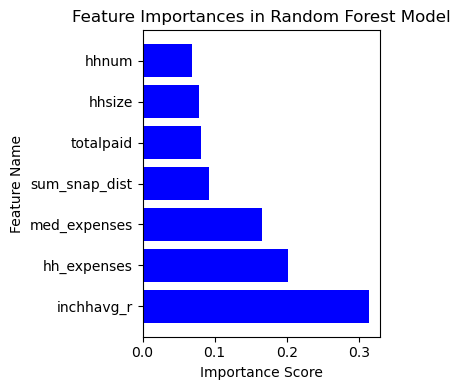

In [41]:
# Build plot
plt.figure(figsize=(4, 4))
plt.barh(importance_df['feature'], importance_df['importance'], color='blue')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title('Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

# STEP 5: NEURAL NETWORK TESTING

## FIRST ITERATION - 4 layers; neurons = 75; 37; 18, 1; activation = relu; and epochs = 100

In [42]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# Checking the number of possible input features
count_input_features = X_train.shape[1]
print("Number of input features:", count_input_features)

Number of input features: 7


In [43]:
# Configuring layers and nodes
snap_model = tf.keras.models.Sequential()

# First hidden layer
snap_model.add(tf.keras.layers.Dense(units=75, activation="relu", input_dim=count_input_features))

# Second hidden layer
snap_model.add(tf.keras.layers.Dense(units=37, activation="relu"))

# Third hidden layer
snap_model.add(tf.keras.layers.Dense(units=18, activation="relu"))

# Output layer
snap_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
snap_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 75)                600       
                                                                 
 dense_1 (Dense)             (None, 37)                2812      
                                                                 
 dense_2 (Dense)             (None, 18)                684       
                                                                 
 dense_3 (Dense)             (None, 1)                 19        
                                                                 
Total params: 4,115
Trainable params: 4,115
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Compile the model
snap_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [46]:
# Train the model
fit_model = snap_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
88/88 [==============================] - 1s 2ms/step - loss: 0.5495 - accuracy: 0.7309
Epoch 2/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4861 - accuracy: 0.7782
Epoch 3/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4692 - accuracy: 0.7857
Epoch 4/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4623 - accuracy: 0.7854
Epoch 5/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4549 - accuracy: 0.7865
Epoch 6/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4508 - accuracy: 0.7933
Epoch 7/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4479 - accuracy: 0.7908
Epoch 8/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4467 - accuracy: 0.7958
Epoch 9/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.7958
Epoch 10/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4388 - accuracy: 0.7951
Epoch 11/

In [47]:
# Evaluate the model using the test data
model_loss, model_accuracy = snap_model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

30/30 - 0s - loss: 0.5740 - accuracy: 0.7411 - 240ms/epoch - 8ms/step
Loss: 0.5739845633506775, Accuracy: 0.7411385774612427


In [ ]:
# Export model
snap_model.save("snap_participation.keras")

## SECOND ITERATION - 4 layers; neurons = 75; 37; 18, 1; activation = tanh; and epochs = 100

In [48]:
# Configuring layers and nodes
snap_model_2 = tf.keras.models.Sequential()

# First hidden layer
snap_model_2.add(tf.keras.layers.Dense(units=75, activation="tanh", input_dim=count_input_features))

# Second hidden layer
snap_model_2.add(tf.keras.layers.Dense(units=37, activation="tanh"))

# Third hidden layer
snap_model_2.add(tf.keras.layers.Dense(units=18, activation="tanh"))

# Output layer
snap_model_2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
snap_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 75)                600       
                                                                 
 dense_5 (Dense)             (None, 37)                2812      
                                                                 
 dense_6 (Dense)             (None, 18)                684       
                                                                 
 dense_7 (Dense)             (None, 1)                 19        
                                                                 
Total params: 4,115
Trainable params: 4,115
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Compile the model
snap_model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [50]:
# Train the model
fit_model_2 = snap_model_2.fit(X_train, y_train, epochs=100)

Epoch 1/100
88/88 [==============================] - 1s 2ms/step - loss: 0.5194 - accuracy: 0.7374
Epoch 2/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.7832
Epoch 3/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4645 - accuracy: 0.7804
Epoch 4/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4651 - accuracy: 0.7861
Epoch 5/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.7857
Epoch 6/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4580 - accuracy: 0.7847
Epoch 7/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4568 - accuracy: 0.7829
Epoch 8/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4565 - accuracy: 0.7818
Epoch 9/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4554 - accuracy: 0.7854
Epoch 10/100
88/88 [==============================] - 0s 2ms/step - loss: 0.4529 - accuracy: 0.7868
Epoch 11/

In [51]:
# Evaluate the model using the test data
model_loss, model_accuracy = snap_model_2.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

30/30 - 0s - loss: 0.4474 - accuracy: 0.7981 - 405ms/epoch - 14ms/step
Loss: 0.447407603263855, Accuracy: 0.7980666160583496


## CONCLUSION: Changing to activation function to tanh may be advantageous because tanh is centered around 0 [-1 to 1], whereas relu is less centered [0 to infinity]. This may be because our y feature is binary in nature (1 = yes, 0 = no).

In [ ]:
# Export model
snap_model_2.save("snap_participation.keras")